In [1]:
import os, time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from scipy.signal import resample

from joblib import dump

In [2]:
SAMPLE_POINTS = 50
INPUT_PARAMETERS = 3

SCRIPT_DIR = os.path.abspath('') #os.path.dirname(__file__); workaround for jupyter notebook

DATA_PATH = os.path.join(SCRIPT_DIR, "data")

In [33]:
data: list[tuple[str, list[tuple]]] = []

In [4]:
def get_data(path: str, data_list: list) -> None:
  for *_, files in os.walk(path):
    if len(files) == 0:
      continue

    for file_name in files:
      if not file_name.endswith(".csv"):
        continue

      file_path = os.path.join(path, file_name)

      data = pd.read_csv(filepath_or_buffer=file_path, delimiter=",")

      points = data[["accelerometer_x", "accelerometer_y", "accelerometer_z"]]
      points = np.array(points, dtype=float)
      class_name = data["gesture"][0]

      scaler = StandardScaler()
      points = scaler.fit_transform(points)

      points_resampled = resample(points, SAMPLE_POINTS)

      data_list.append((class_name, points_resampled))

In [34]:
get_data(DATA_PATH, data)

In [6]:
print(data[0])

('TILT_LEFT', array([[ 1.05040135,  0.68549773,  1.20117973],
       [ 1.30733567,  0.69458869,  1.53053736],
       [ 0.97419006,  0.71398958,  1.0604099 ],
       [ 1.20434251,  0.7941049 ,  1.13341824],
       [ 1.51307621,  0.66743038,  1.46703997],
       [ 1.35007694,  0.77012707,  1.27061208],
       [ 1.26855382,  1.42513892,  0.91398386],
       [ 1.45871016,  1.83071979,  0.90812762],
       [ 1.44862443,  1.45397119,  0.99406986],
       [ 1.32554076,  1.09045373,  0.97238284],
       [ 1.39618087,  1.27790317,  0.99288266],
       [ 1.3875687 ,  1.37378123,  1.00280163],
       [ 1.19811343,  1.09224004,  0.91479924],
       [ 1.20638083,  1.0829591 ,  0.91110759],
       [ 1.31437035,  1.44365766,  1.02471845],
       [ 1.07345332,  1.44716186,  0.99288266],
       [ 0.69839736,  0.98973065,  0.75866206],
       [ 0.66172303,  0.73800974,  0.58857332],
       [ 0.70547075,  0.79150105,  0.60594442],
       [ 0.34067604,  0.561077  ,  0.61738307],
       [-0.19440493,  0.00

In [35]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


{'TILT_RIGHT', 'TILT_LEFT', 'THROW', 'NEUTRAL'}
{0, 1, 2, 3}
4
(449, 50, 3) (113, 50, 3) (449, 4) (113, 4)


using joblib to save encoding to a file and later pick it up for the recogniser.py to assign encoded labels to correct name.

In [36]:
dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [59]:
class NN:   

  def __init__(self) -> None:
    self.model = Sequential()

    self.model.add(LSTM(64, input_shape=(SAMPLE_POINTS, INPUT_PARAMETERS)))
    self.model.add(Dense(32, activation="tanh"))

    self.model.add(Dense(len(set(labels)), activation='softmax'))

    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    self.stop_early = EarlyStopping(monitor='val_loss', patience=3)

  def train(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray) -> None:
    # Train the model
    self.history = self.model.fit(
      X_train,
      y_train,
      epochs=24,
      batch_size=24,
      validation_data=(X_test, y_test),
      verbose=1,
      callbacks=[self.reduce_lr, self.stop_early]
    )

  def summarise(self) -> None:
    self.model.summary()

  def plot(self) -> None:
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    accuracy = self.history.history['accuracy']
    val_accuracy = self.history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

  def predict(self, X_test: np.ndarray, y_test: np.ndarray, labels_train: list[str]) -> None:
    # let the model make predictions for our training data
    y_predictions = self.model.predict(X_test)
    

    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_train)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')

In [60]:
nn = NN()
nn.train(X_train, y_train, X_test, y_test)


Epoch 1/24
19/19 [==============================] - 3s 39ms/step - loss: 1.2627 - accuracy: 0.4855 - val_loss: 1.0799 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 2/24
19/19 [==============================] - 0s 15ms/step - loss: 0.8865 - accuracy: 0.6860 - val_loss: 0.6956 - val_accuracy: 0.7699 - lr: 0.0010
Epoch 3/24
19/19 [==============================] - 0s 14ms/step - loss: 0.5659 - accuracy: 0.8196 - val_loss: 0.4401 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 4/24
19/19 [==============================] - 0s 14ms/step - loss: 0.3296 - accuracy: 0.9310 - val_loss: 0.2817 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 5/24
19/19 [==============================] - 0s 15ms/step - loss: 0.2043 - accuracy: 0.9399 - val_loss: 0.2288 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 6/24
19/19 [==============================] - 0s 15ms/step - loss: 0.1708 - accuracy: 0.9488 - val_loss: 0.2282 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 7/24
19/19 [==============================] - 0s 16ms/step - loss: 0.1

In [61]:
nn.summarise()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 64)                17408     
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 4)                 132       
                                                                 
Total params: 19620 (76.64 KB)
Trainable params: 19620 (76.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


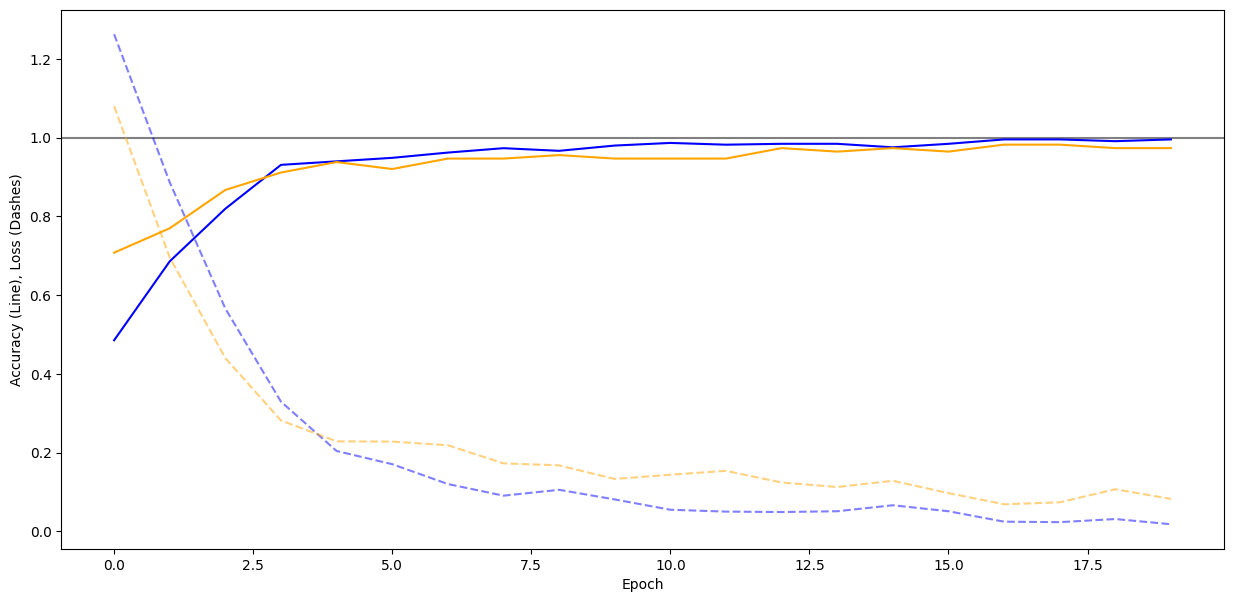

In [62]:
nn.plot()

4/4 [==============================] - 1s 4ms/step


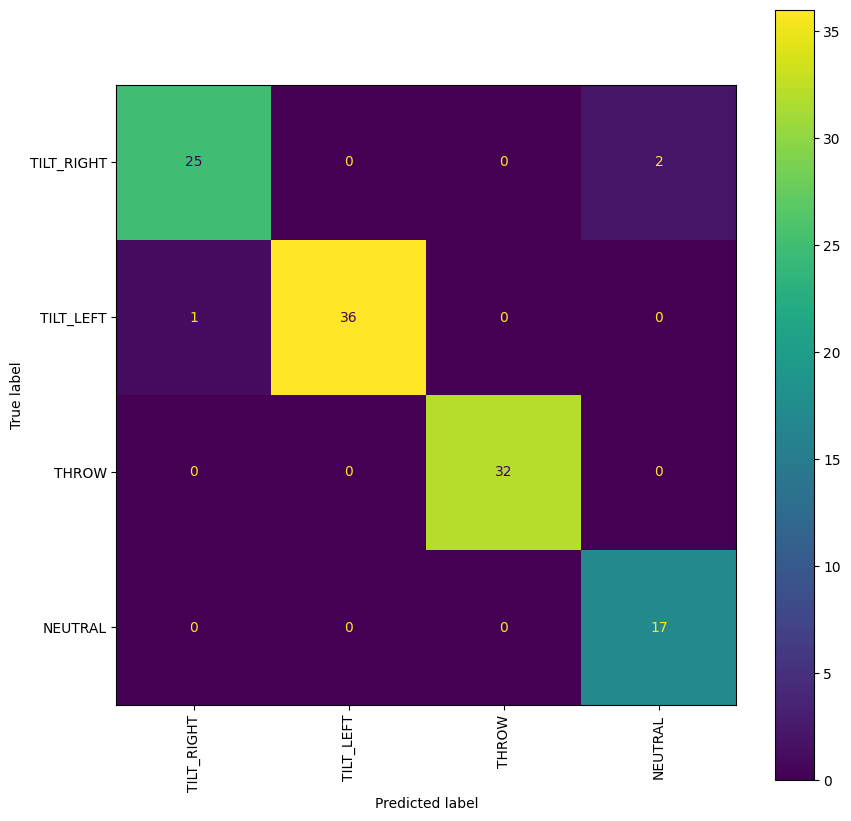

In [63]:
nn.predict(X_test, y_test, labels)

In [64]:
nn.model.save("lstm_model")

INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets
